In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.under_sampling import RandomUnderSampler


In [2]:
data = pd.read_csv('corona_tested_individuals_ver_0083.english.csv')

## Data Overview

## Model Predictors and Exact Variable Names (True = 1, False = 0)
* **Age over 60** - Age_60_and_above
* **Sex** - Male (Male=1, Female=0)
* **Cough** - Cough
* **Shortness of breath** - Shortness_of_breath
* **Fever** - Fever
* **Sore throat** - Sore_throat
* **Headache** - Headache
* **Test Indication** - Important thing in this is whether the patient contacted with a confirmed patient or not

Source: https://data.gov.il/dataset/covid-19

Translated into English by: 

In [5]:
data.value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

## Preparing Data



In [4]:
data['age_60_and_above'].value_counts() 

No     119695
Yes     23929
Name: age_60_and_above, dtype: int64

In [5]:
data['age_60_and_above'].shape

(158606,)

## Dropping NA Values

In [6]:
#Dropping NA Values
data = data.dropna()
print(data.shape)

(143502, 10)


## Converting Columns to accepted format

In [7]:

def contact_with_confirmed_convert(x):
    row = dict(x)
    test_indication = row['test_indication']
    
    if test_indication == 'Contact with confirmed':
        return 1
    else:
        return 0
    
def gender(x):
    row = dict(x)
    gender = row['gender'].lower()
    
    if gender == 'male':
        return 1
    else:
        return 0 
def gender(x):
    row = dict(x)
    gender = row['gender'].lower()
    
    if gender == 'male':
        return 1
    else:
        return 0 

def age_60_and_above(x):
    row = dict(x)
    age = row['age_60_and_above']
    
    if age == 'Yes':
        return 1
    else:
        return 0 
    
def corona_result(x):
    row = dict(x)
    corona_result = row['corona_result'].lower()
    
    if corona_result == 'positive':
        return 1
    else:
        return 0 
    
data['contact_with_confirmed'] = data.apply(lambda row: contact_with_confirmed_convert(row), axis = 1)
data['gender'] = data.apply(lambda row: gender(row), axis = 1)
data['age_60_and_above'] = data.apply(lambda row: age_60_and_above(row), axis = 1)
data['corona_result'] = data.apply(lambda row: corona_result(row), axis = 1)

In [8]:
data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication,contact_with_confirmed
0,2020-11-12,0,0,0,0,0,0,0,1,Other,0
1,2020-11-12,0,1,0,0,0,0,0,1,Other,0
2,2020-11-12,0,0,0,0,0,0,1,0,Other,0
3,2020-11-12,0,0,0,0,0,0,0,1,Other,0
4,2020-11-12,0,1,0,0,0,0,0,1,Contact with confirmed,1


In [9]:
data['contact_with_confirmed'].value_counts()

0    139051
1      4451
Name: contact_with_confirmed, dtype: int64

In [10]:
del data['test_indication']

## Gradient Boosting Classifier

**Learning Rate**: Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

**N_estimators**: The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

**Max Depth**: The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.



In [11]:
def build_model(X,y):
    learning_rate = 0.2
    no_of_estimators = 200
    max_depth = 3
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    model = GradientBoostingClassifier(learning_rate=0.2,n_estimators=no_of_estimators,max_depth=max_depth)
    model.fit(X_train, y_train)
    return X_train, X_test, y_train, y_test, model

def predict(X_test):
    y_pred = model.predict(X_test)
    return y_pred

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#Selecting the X and Y columns
X = data[['cough','fever','sore_throat','shortness_of_breath','head_ache','age_60_and_above','gender','contact_with_confirmed']]
y = data[['corona_result']]



In [13]:
from sklearn.metrics import recall_score, precision_score, classification_report, plot_roc_curve

def metrics(y_test,y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

    recall = recall_score(y_test,y_pred)
    print("Recall: %.2f%%" % (recall * 100.0))

    precision = precision_score(y_test,y_pred)
    print("Precision: %.2f%%" % (precision * 100.0))
    
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_conf_matrix(y_test,y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)

    labels = ['Class 0', 'Class 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()
    
def classification_report_func(y_test,y_pred,target):
    report = classification_report(y_test, y_pred,target_names=['class 0','class 1'])
    return report

def roc_curve(model,X_test,y_test):
    plot_roc_curve(model, X_test, y_test)
    return plot_roc_curve

c:\users\user5\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 97.87%
Recall: 37.27%
Precision: 80.96%
              precision    recall  f1-score   support

     class 0       0.98      1.00      0.99     27845
     class 1       0.81      0.37      0.51       856

    accuracy                           0.98     28701
   macro avg       0.90      0.68      0.75     28701
weighted avg       0.98      0.98      0.97     28701

Confusion matrix:
 [[27770    75]
 [  537   319]]


<ipython-input-13-5859d5ea62b4>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-13-5859d5ea62b4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


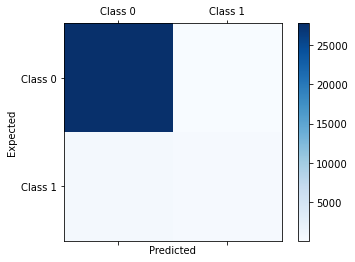

<function sklearn.metrics._plot.roc_curve.plot_roc_curve(estimator, X, y, *, sample_weight=None, drop_intermediate=True, response_method='auto', name=None, ax=None, pos_label=None, **kwargs)>

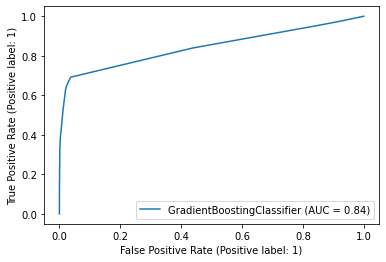

In [14]:
X_train, X_test, y_train, y_test, model = build_model(X,y)
y_pred = predict(X_test)
metrics(y_test,y_pred)
classification_report = classification_report_func(y_test,y_pred,target=['class 0','class 1'])
print(classification_report)
plot_conf_matrix(y_test,y_pred)
roc_curve(model,X_test,y_test)

In [65]:
#y_test['corona_result'].value_counts()

## Python imbalanced-learn module
A number of more sophisticated resapling techniques have been proposed in the scientific literature.

For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

In [21]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X, y)

In [29]:
X_train, X_test, y_train, y_test, model = build_model(X_rus,y_rus)
y_pred = predict(X_test)
metrics(y_test,y_pred)
print(y_test.head(),y_pred)
classification_report(y_test,y_pred)

classification_report = classification_report_func(y_test,y_pred)
plot_conf_matrix(y_test,y_pred)
roc_curve(model,X_test,y_test)


c:\users\user5\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 82.59%
Recall: 69.91%
Precision: 94.23%
      corona_result
1882              0
4675              1
4177              0
2344              0
4932              1 [0 1 0 ... 1 1 1]


TypeError: 'str' object is not callable

## Under-sampling: Cluster Centroids
This technique performs under-sampling by generating centroids based on clustering methods. The data will be previously grouped by similarity, in order to preserve information.

Method that under samples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm. This algorithm keeps N majority samples by fitting the KMeans algorithm with N cluster to the majority class and using the coordinates of the N cluster centroids as the new majority samples.

In [31]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids()

X_cc, y_cc = cc.fit_resample(X[0:40000], y[0:40000])

c:\users\user5\appdata\local\programs\python\python38-32\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:172: ConvergenceWarning: Number of distinct clusters (43) found smaller than n_clusters (1113). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


In [1]:
y_cc['corona_result'].value_counts()
X_train, X_test, y_train, y_test, model = build_model(X_cc,y_cc)
y_pred = predict(X_test)
metrics(y_test,y_pred)
print(y_test.head(),y_pred)
classification_report(y_test,y_pred,target_names = ['class 0', 'class 1'])

classification_report = classification_report_func(y_test,y_pred)
plot_conf_matrix(y_test,y_pred)
roc_curve(model,X_test,y_test)


## Assigment: 

Try Oversampling Technique SMOTE, Compare and Contrast it with Undersampling Techniques and observe which one is better in our case
## Oversampling

**SMOTE (Synthetic Minority Oversampling TEchnique)** consists of synthesizing elements for the minority class, based on those that already exist. It works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.



In [46]:
from imblearn.over_sampling import SMOTE, ADASYN
X_smote, y_smote = SMOTE().fit_resample(X, y)


In [48]:
y_smote['corona_result'].value_counts()

1    139238
0    139238
Name: corona_result, dtype: int64

## Saving the Model




In [1]:
import pickle

filename = 'finalized_model_classifying_symptoms.sav'
pickle.dump(model, open(filename, 'wb'))